In [1]:
from extract_hkm_cmdty import *
from load_futures_data import load_gsci_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

# Commodity Return Replication – Walkthrough
This notebook outlines the steps taken to generate an approximate replication of the commodity return series presented in He, Kelly, and Manela (2017).

## Overview

He, Kelly, and Manela constructed monthly returns for 23 commodities selected from a larger set of 31 commodities originally studied by Yang (2013). These commodities were chosen based on data availability from the Commodity Research Bureau (CRB), requiring at least 25 years of monthly returns data. He, Kelly, and Manela employed an equal-weighted portfolio of all futures contracts with maturities of four months or less, slightly modifying Yang’s original method, which used contracts with maturities between one month and twelve months.

*Note: the Yang paper ranges from 197101-200812 and hkm ranges from 198609-201212*

However, when attempting direct replication, we encountered significant data limitations. The CRB dataset, as originally utilized by Yang and subsequently He, Kelly, and Manela, is not readily accessible. Matching the precise contract numbers listed in Yang’s Table 1 ("N" values) was also impractical given current dataset constraints.

> Though it may not be accurate since both Yang and HKM papers did not mention the yearspan of the commodities they have collected, since they use the same dataset, we sort the Yang's commoditeis table by N values to estimate which commodities might be chosen by HKM (as they want at least 25 years of monthly return)

| Commodity     | Symbol | N   |
| ------------- | ------ | --- |
| Wheat         | W-     | 468 |
| Soybean meal  | SM     | 468 |
| Soybeans      | S-     | 468 |
| Oats          | O-     | 468 |
| Lumber        | LB     | 468 |
| Corn          | C-     | 468 |
| Cotton        | CT     | 452 |
| Cocoa         | CC     | 452 |
| Coffee        | KC     | 420 |
| Silver        | SI     | 419 |
| Orange juice  | JO     | 448 |
| Rough rice    | RR     | 265 |
| Lean hogs     | LH     | 468 |
| Live cattle   | LC     | 468 |
| Feeder cattle | FC     | 443 |
| Natural gas   | NG     | 216 |
| Gold          | GC     | 400 |
| Heating oil   | HO     | 345 |
| Gasoline      | RB     | 275 |
| Barley        | WA     | 235 |
| Canola        | WC     | 377 |
| Butter        | 02     | 141 |
| Crude oil     | CL     | 295 |


## Current Approach -- GSCI Indices
Fortunately, He, Kelly, and Manela mentioned an alternative method tested by Koijen, Moskowitz, Pedersen, and Vrugt (2018) (KMPV), which closely approximated their original findings. The KMPV paper explicitly provided Bloomberg tickers of 24 different commodities, enabling direct extraction of reliable and consistent monthly return data.

Thus, for our replication, we adopted the Bloomberg database following KMPV’s approach. Since KMPV did not explicitly present a calculation formula but rather directly extracted monthly returns from Bloomberg, our replication followed the same straightforward procedure.



In [2]:
df_return = load_gsci_data()
df_return.info()

<class 'pandas.core.frame.DataFrame'>
Index: 728 entries, 196411 to 202506
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          728 non-null    datetime64[ns]
 1   SPGCBRP Index_PX_LAST_Return  317 non-null    float64       
 2   SPGCGOP Index_PX_LAST_Return  317 non-null    float64       
 3   SPGCCLP Index_PX_LAST_Return  461 non-null    float64       
 4   SPGCHUP Index_PX_LAST_Return  449 non-null    float64       
 5   SPGCHOP Index_PX_LAST_Return  509 non-null    float64       
 6   SPGCNGP Index_PX_LAST_Return  377 non-null    float64       
 7   SPGCCTP Index_PX_LAST_Return  581 non-null    float64       
 8   SPGCKCP Index_PX_LAST_Return  533 non-null    float64       
 9   SPGCCCP Index_PX_LAST_Return  497 non-null    float64       
 10  SPGCSBP Index_PX_LAST_Return  629 non-null    float64       
 11  SPGCSOP Index_PX_LAST_Return 

In [3]:
df_return.tail(5)

,Date,SPGCBRP Index_PX_LAST_Return,SPGCGOP Index_PX_LAST_Return,SPGCCLP Index_PX_LAST_Return,SPGCHUP Index_PX_LAST_Return,SPGCHOP Index_PX_LAST_Return,SPGCNGP Index_PX_LAST_Return,SPGCCTP Index_PX_LAST_Return,SPGCKCP Index_PX_LAST_Return,SPGCCCP Index_PX_LAST_Return,...,SPGCLHP Index_PX_LAST_Return,SPGCFCP Index_PX_LAST_Return,SPGCLCP Index_PX_LAST_Return,SPGCGCP Index_PX_LAST_Return,SPGCSIP Index_PX_LAST_Return,SPGCIAP Index_PX_LAST_Return,SPGCIKP Index_PX_LAST_Return,SPGCILP Index_PX_LAST_Return,SPGCIZP Index_PX_LAST_Return,SPGCICP Index_PX_LAST_Return
yyyymm,,,,,,,,,,,,,,,,,,,,,
202502,2025-02-28,-0.032959,-0.028765,-0.035269,-0.023258,-0.010092,0.257536,-0.026085,0.011168,-0.181161,...,-0.073879,-0.009924,-0.047701,0.004763,-0.033119,0.003324,0.011188,0.021894,0.016528,0.036241
202503,2025-03-31,0.034188,0.016440,0.029411,0.028073,-0.001000,0.060252,0.024215,0.017960,-0.133932,...,0.009050,0.038689,0.076125,0.095406,0.098902,-0.029835,0.025278,0.006100,0.021178,0.036243
202504,2025-04-30,-0.176246,-0.114556,-0.179416,-0.115157,-0.103167,-0.215774,-0.023963,0.061948,0.133033,...,0.031488,0.016751,0.023324,0.053582,-0.060372,-0.056096,-0.034990,-0.024421,-0.096317,-0.057642
202505,2025-05-30,0.034989,-0.006110,0.051259,0.013584,0.015693,-0.048471,-0.014541,-0.145477,0.101722,...,0.034167,0.012880,0.026952,-0.009677,0.006123,0.015721,-0.016660,-0.003130,0.009227,0.044607
202506,2025-06-23,0.216689,0.260221,0.236079,0.155847,0.256024,0.116291,-0.010310,-0.074109,-0.108304,...,0.053268,0.012130,0.002269,0.021203,0.090602,0.046000,-0.017343,0.013028,0.000765,0.016218


In [4]:
hkm_df = extract_hkm_cmdty()

In [5]:
hkm_df.tail(5)

,Commod_01,Commod_02,Commod_03,Commod_04,Commod_05,Commod_06,Commod_07,Commod_08,Commod_09,Commod_10,...,Commod_14,Commod_15,Commod_16,Commod_17,Commod_18,Commod_19,Commod_20,Commod_21,Commod_22,Commod_23
yyyymm,,,,,,,,,,,,,,,,,,,,,
201208,-0.0057,0.1002,0.0883,0.0801,0.0291,0.0444,0.0095,0.1050,0.1311,-0.0655,...,0.0297,0.0611,0.0817,0.1266,-0.0392,0.0656,0.1165,0.0673,-0.0175,0.0100
201209,-0.0558,-0.0366,-0.0479,-0.0950,-0.0196,0.0499,0.0847,-0.0085,-0.0490,0.0518,...,-0.0702,0.0181,0.0800,0.0228,0.0123,-0.0905,0.0951,-0.0907,0.0146,-0.0639
201210,-0.0006,-0.0521,-0.0616,-0.0081,0.0113,-0.0313,-0.0653,-0.0255,-0.0627,-0.1149,...,0.0488,-0.0498,-0.0558,-0.0519,-0.0422,-0.0342,-0.0675,-0.0138,-0.0429,0.0288
201211,-0.0079,0.0504,0.0203,0.0355,-0.0179,-0.0048,0.0329,0.0058,0.1388,-0.0705,...,-0.0611,0.1182,0.0168,0.0480,0.0089,-0.0676,0.0272,-0.0855,-0.0205,-0.0328
201212,-0.0751,-0.1107,0.0197,0.0166,0.0403,-0.0216,0.0007,-0.0109,-0.0572,-0.0461,...,-0.0860,0.0223,-0.0417,0.0125,-0.0268,-0.0150,-0.0963,-0.0262,-0.1042,0.0028


## Matching Procedure

Given that He, Kelly, and Manela presented anonymized commodities without explicit tickers or identifiers, we needed a systematic approach to match our Bloomberg-based commodities with the paper's 23 commodities. We computed the Pearson correlation matrix between our monthly return series and those presented in the paper. Then, we used the linear assignment algorithm to find the optimal one-to-one commodity matches, maximizing the total correlation between the two datasets.

In [6]:
from replicate_cmdty import generate_corr_matrix 

In [7]:
corr_matrix = generate_corr_matrix(df_return, hkm_df)

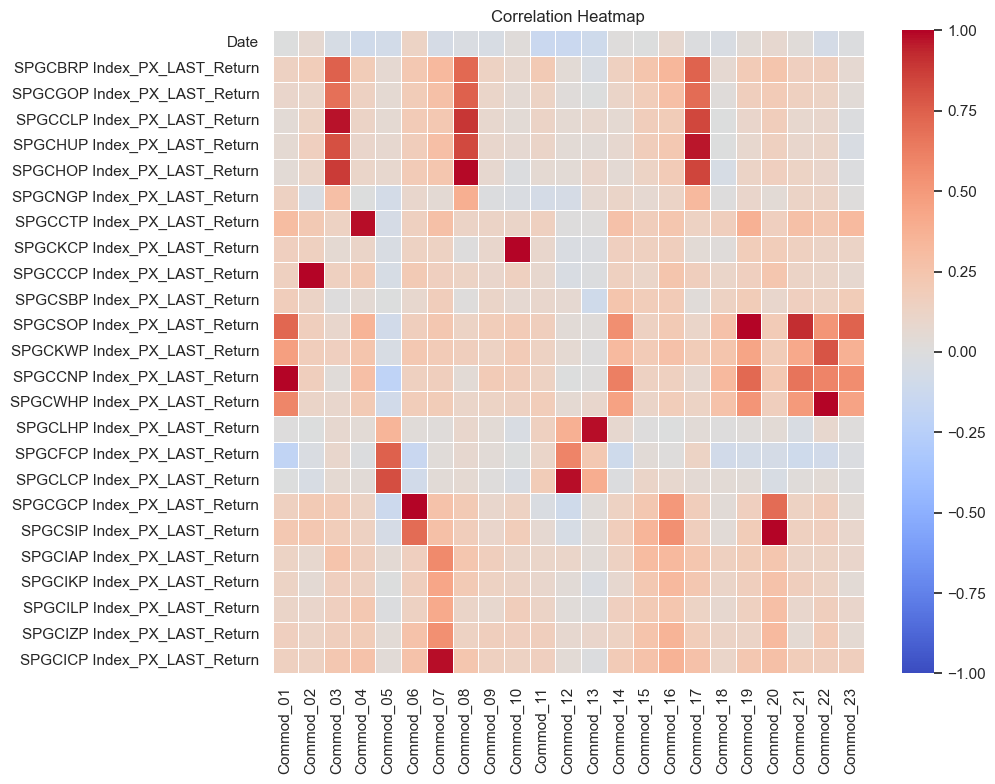

In [8]:
plt.figure(figsize=(10, 8))
corr_matrix_float = corr_matrix.astype(float)
sns.heatmap(
    corr_matrix_float,
    annot=False,      
    fmt=".2f",       
    cmap="coolwarm",  
    vmin=-1, vmax=1,  
    square=True,
    linewidths=0.5,
    cbar=True
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [9]:
def decide_optimal_pairs(corr_matrix):
    cost_matrix = -corr_matrix.values.astype(float)

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    optimal_pairs = []

    for r, c in zip(row_ind, col_ind):
        row_label = corr_matrix.index[r]
        col_label = corr_matrix.columns[c]
        corr_value = corr_matrix.iloc[r, c]
        optimal_pairs.append((row_label, col_label, corr_value))

    optimal_pairs_df = pd.DataFrame(optimal_pairs, columns=['Commodity_1', 'Commodity_2', 'Correlation'])

    optimal_pairs_df = optimal_pairs_df.sort_values(by='Correlation', ascending=False)
    
    return optimal_pairs_df.reset_index(drop = True), col_ind, row_ind

In [10]:
optimal_pairs_df, col_ind, row_ind = decide_optimal_pairs(corr_matrix_float)

In [11]:
optimal_pairs_df

,Commodity_1,Commodity_2,Correlation
0,SPGCGCP Index_PX_LAST_Return,Commod_06,0.997829
1,SPGCSIP Index_PX_LAST_Return,Commod_20,0.996492
2,SPGCCCP Index_PX_LAST_Return,Commod_02,0.995033
3,SPGCKCP Index_PX_LAST_Return,Commod_10,0.994202
4,SPGCWHP Index_PX_LAST_Return,Commod_22,0.993406
5,SPGCSOP Index_PX_LAST_Return,Commod_19,0.993210
6,SPGCCNP Index_PX_LAST_Return,Commod_01,0.992284
7,SPGCHOP Index_PX_LAST_Return,Commod_08,0.989293
8,SPGCICP Index_PX_LAST_Return,Commod_07,0.983833
9,SPGCCTP Index_PX_LAST_Return,Commod_04,0.980607


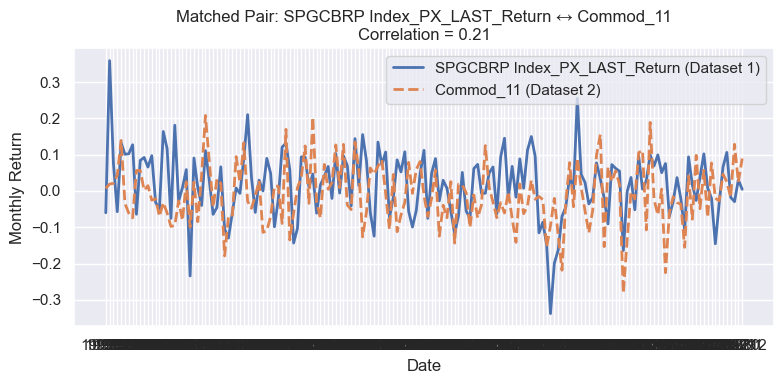

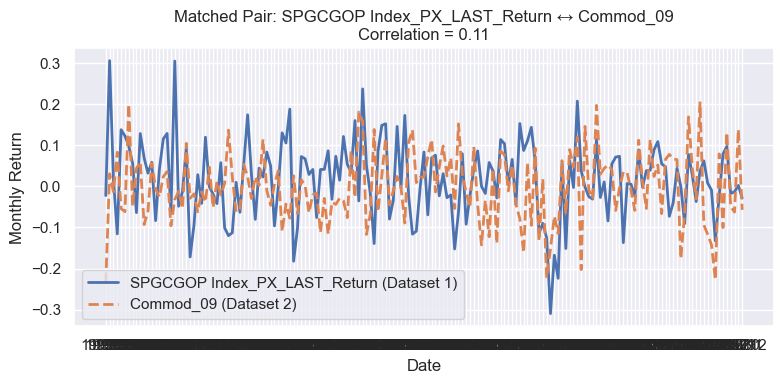

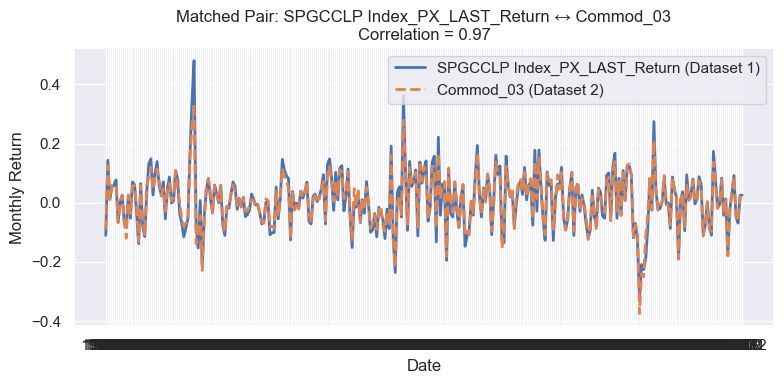

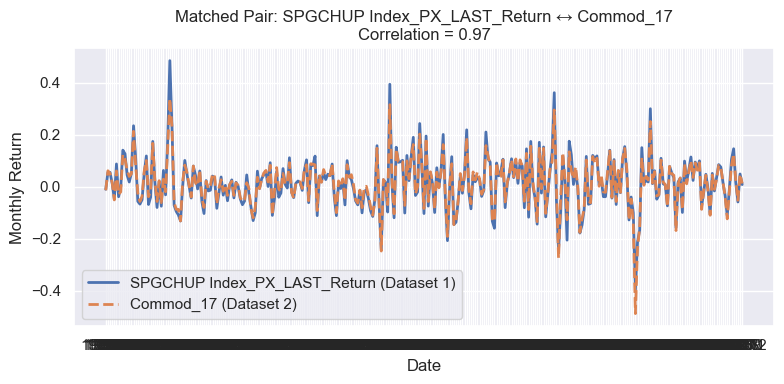

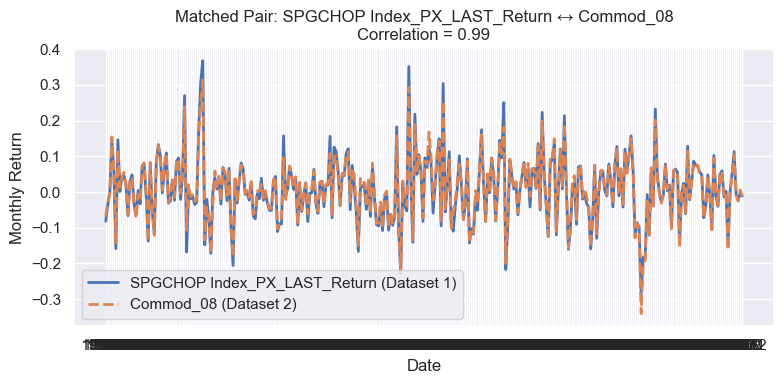

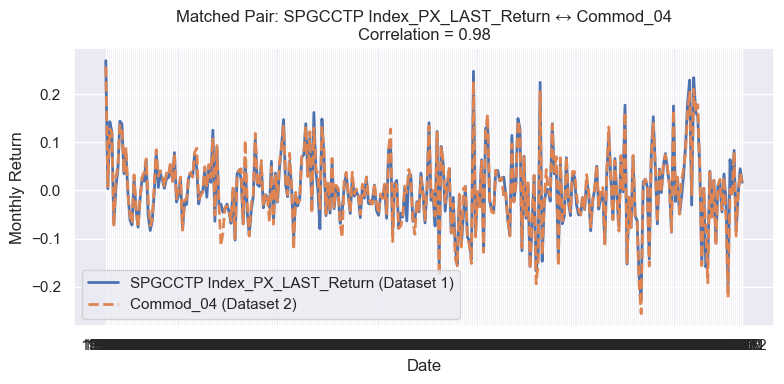

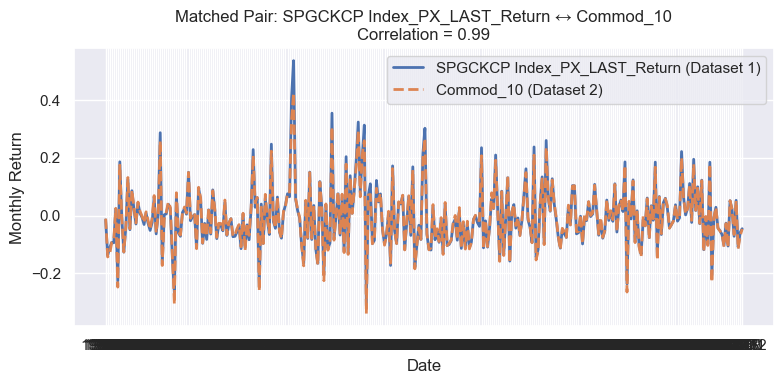

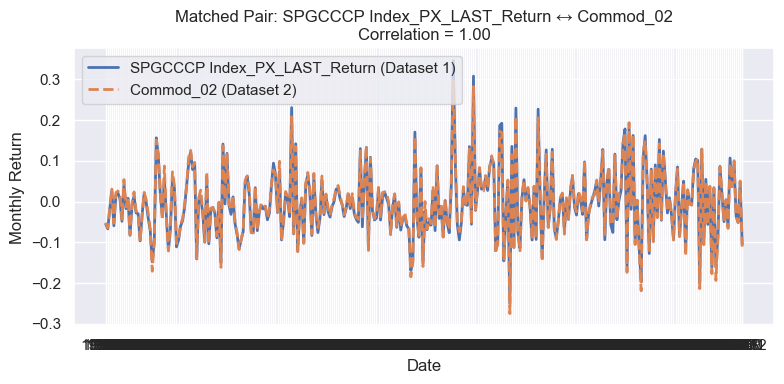

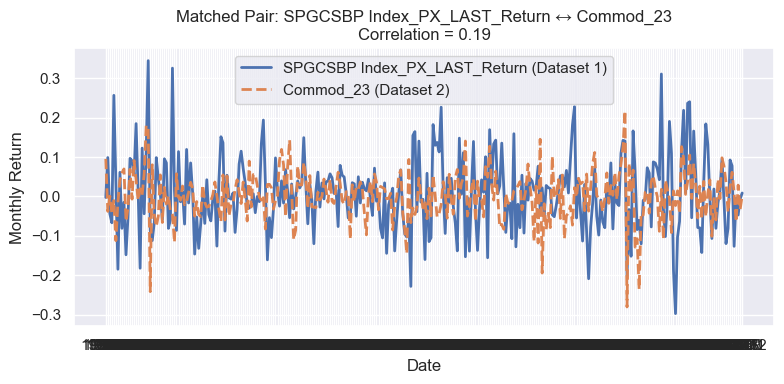

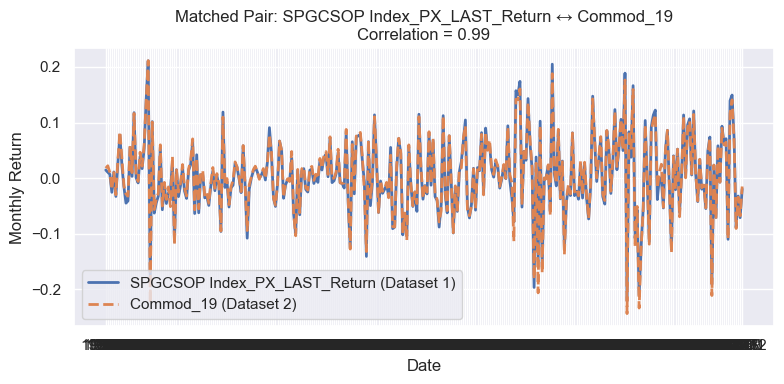

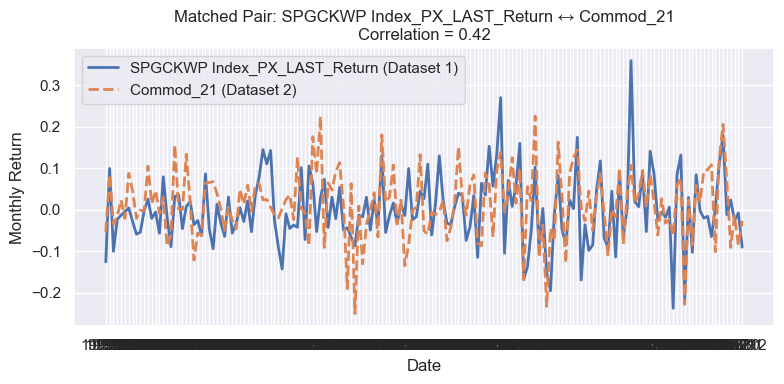

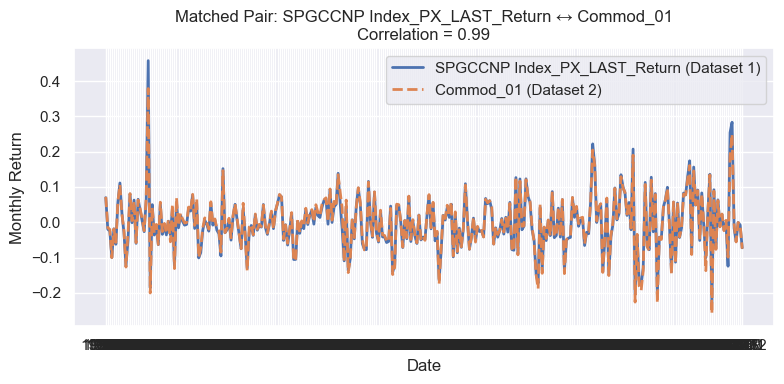

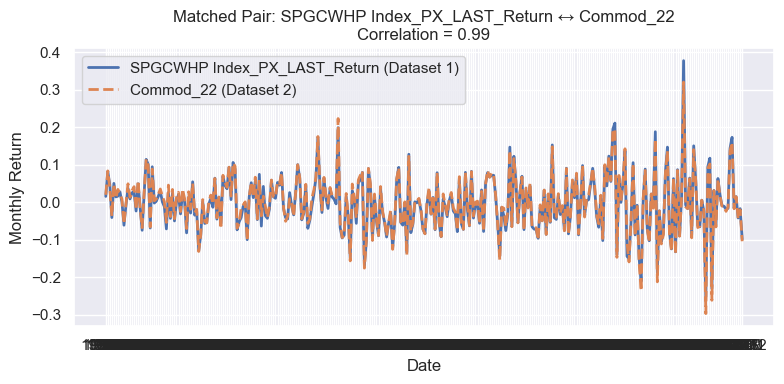

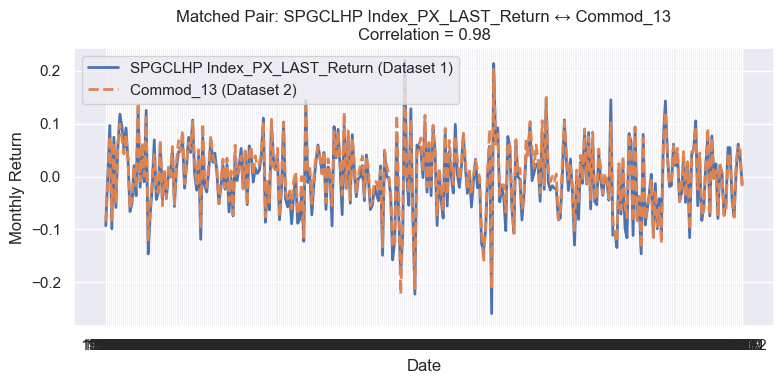

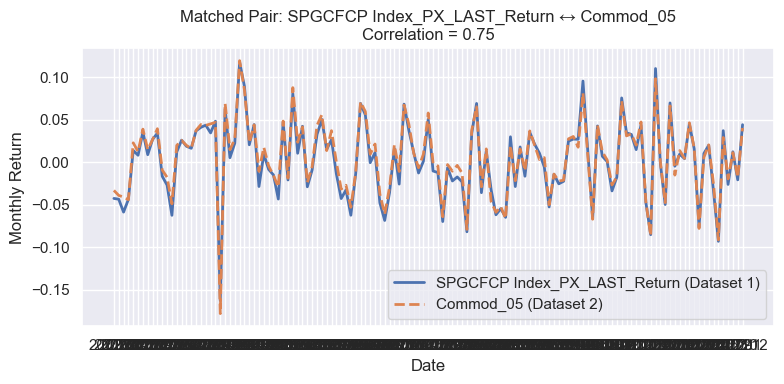

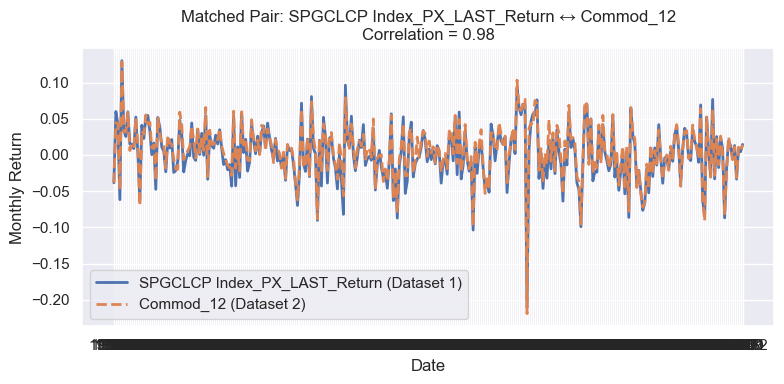

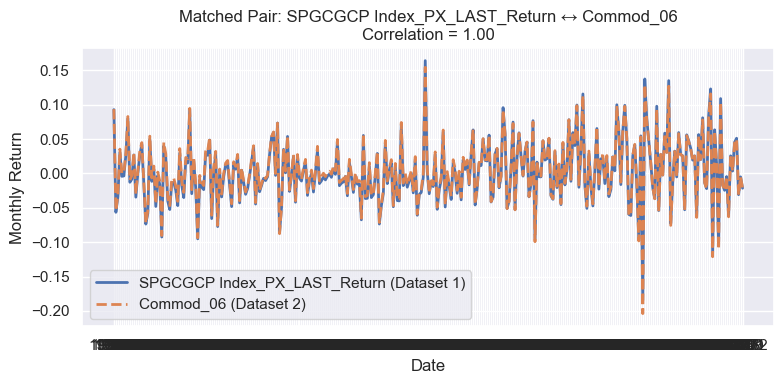

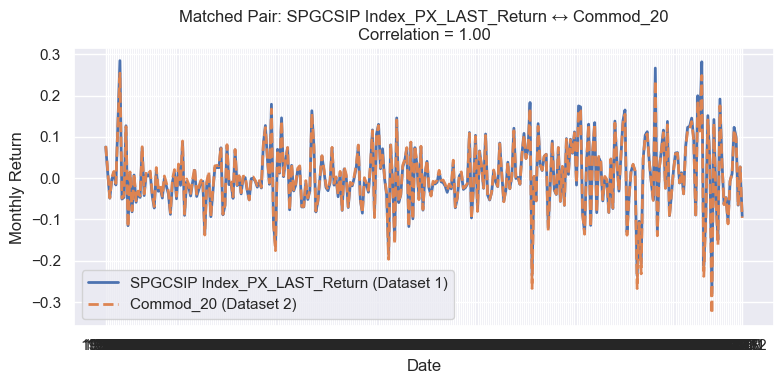

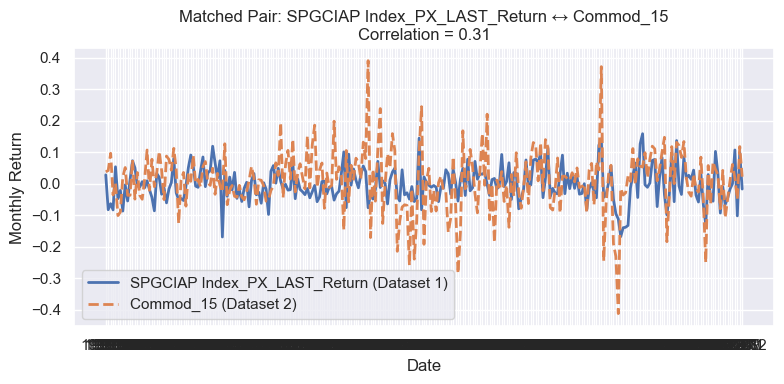

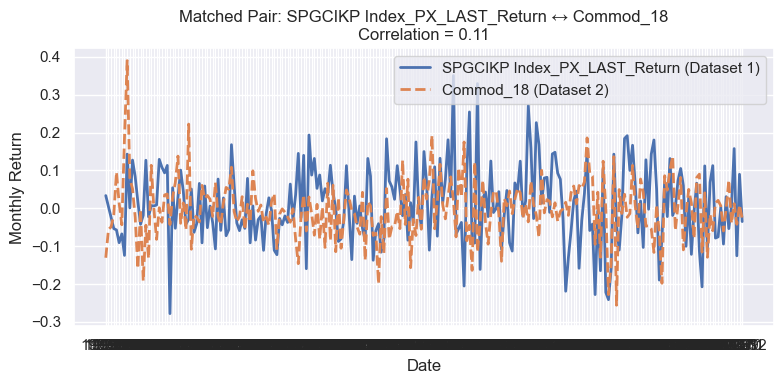

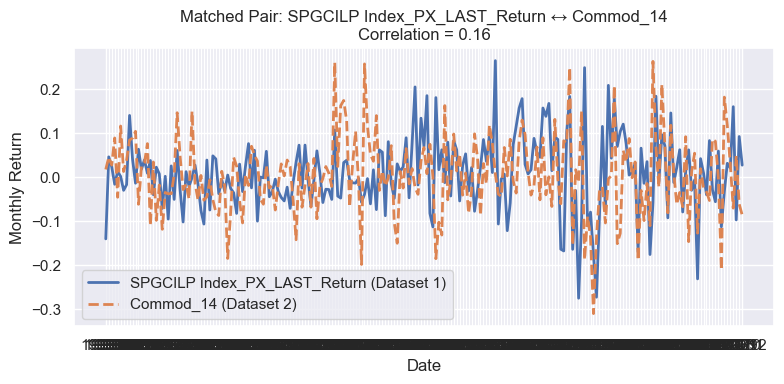

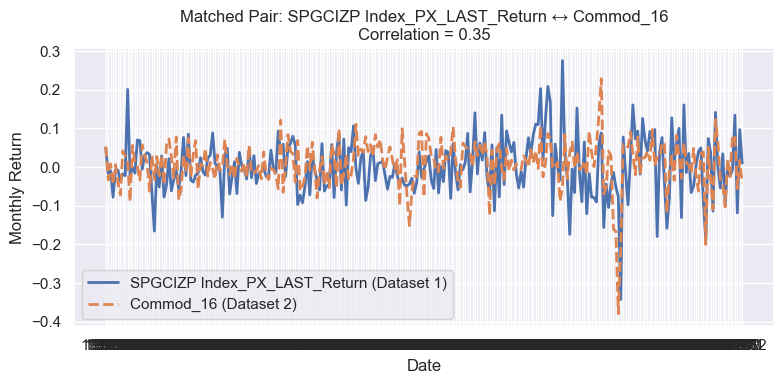

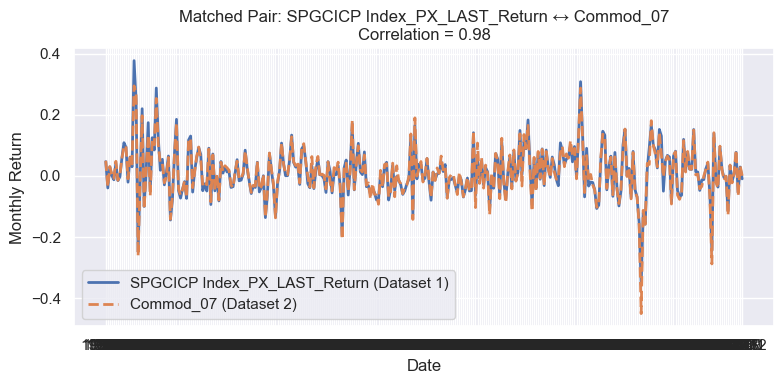

In [12]:
df1 = df_return.copy()
df2 = hkm_df.copy()

for r, c in zip(row_ind, col_ind):
    commodity_1 = corr_matrix.index[r]
    commodity_2 = corr_matrix.columns[c]

    merged = pd.DataFrame({
        f'd1_{commodity_1}': df1[commodity_1],
        f'd2_{commodity_2}': df2[commodity_2]
    }).dropna()

    plt.figure(figsize=(8, 4))
    plt.plot(merged.index, merged[f'd1_{commodity_1}'], label=f'{commodity_1} (Dataset 1)', linewidth=2)
    plt.plot(merged.index, merged[f'd2_{commodity_2}'], label=f'{commodity_2} (Dataset 2)', linewidth=2, linestyle='--')

    plt.title(f'Matched Pair: {commodity_1} ↔ {commodity_2}\nCorrelation = {corr_matrix.iloc[r, c]:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# TODO: ONLY Inlucde those with over 0.8 corr?

## Generate Standardized table 

In [15]:
list_of_return_ticker = optimal_pairs_df["Commodity_1"].to_list()

In [17]:
def wide_to_long_returns(df, list_of_return_ticker):
    """
    Converts a wide-format return DataFrame to long-format with columns: ds, unique_id, y
    """
    if 'Date' in df.columns:
        id_col = 'Date'
    elif 'yyyymm' in df.columns:
        id_col = 'yyyymm'
    else:
        raise ValueError('No date column found!')

    cols = [id_col] + list_of_return_ticker
    df_sub = df[cols].copy()

    df_long = df_sub.melt(id_vars=id_col, value_vars=list_of_return_ticker,
                          var_name='unique_id', value_name='y')
    df_long = df_long.rename(columns={id_col: 'ds'})

    df_long = df_long.dropna(subset=['y'])

    df_long = df_long.sort_values(['unique_id', 'ds']).reset_index(drop=True)

    return df_long


In [18]:
gsci_replication_df = wide_to_long_returns(df_return, list_of_return_ticker)

In [19]:
gsci_replication_df.head(5)

,ds,unique_id,y
0,1999-02-26,SPGCBRP Index_PX_LAST_Return,-0.060203
1,1999-03-31,SPGCBRP Index_PX_LAST_Return,0.359040
2,1999-04-30,SPGCBRP Index_PX_LAST_Return,0.075051
3,1999-05-28,SPGCBRP Index_PX_LAST_Return,-0.057141
4,1999-06-30,SPGCBRP Index_PX_LAST_Return,0.132458


The commodities with correlations above 0.90 are primarily the highly liquid, major contracts in the GSCI—such as Gold, Silver, Copper, Cotton, Lean Hogs, Live Cattle, Crude Oil, and Unleaded Gasoline. These very high correlations suggest that both our replication approach and the official GSCI series are based on the same or highly similar underlying futures data, contract rolling methodologies, and return calculations. This result is expected if both datasets are constructed using standard, well-documented procedures.

A source of deviation is the difference in the underlying universe of commodities. The original dataset selects 23 commodities from a broader pool of 31, while our replication process attempts to match 23 out of 24 available contracts. As a result, some mismatches are almost inevitable. Commodities with correlations above 0.90 are likely to be those that overlap directly between the two datasets, while those with lower correlations are often not present in  lists provided in KMPV. Nonetheless, the high degree of agreement for the major contracts provides strong evidence that the GSCI index can serve as an effective basis for replicating the methodology in HKM.

It does make sense if you check the summary table below, though still, it is an approximation as the author did not use GCSI data as the source of constraint of at least 25 years of record, but we can see that, the tickers should be have at least 37 years of record to have 25 years of record as of 2013 when the paper was published. 

Also, as the table shown above sorted by N values in Yang's paper, we can see have 15 of the 23 commodities available in our GSCI tickers list, which, if not by coincidence, just covers... 

In [23]:
import pandas as pd

def summary_by_ticker(df, date_col='Date'):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    result = []
    for col in df.columns:
        if col == date_col:
            continue
        valid = df[[date_col, col]].dropna()
        count = len(valid)
        min_date = valid[date_col].min()
        max_date = valid[date_col].max()
        if pd.notna(min_date) and pd.notna(max_date):
            yearspan = max_date.year - min_date.year + 1
        else:
            yearspan = None
        result.append({
            'ticker': col,
            'length': count,
            'min_date': min_date,
            'max_date': max_date,
            'yearspan': yearspan
        })
    return pd.DataFrame(result)

summary_df = summary_by_ticker(df_return, date_col='Date')
summary_df


,ticker,length,min_date,max_date,yearspan
0,SPGCBRP Index_PX_LAST_Return,317,1999-02-26,2025-06-23,27
1,SPGCGOP Index_PX_LAST_Return,317,1999-02-26,2025-06-23,27
2,SPGCCLP Index_PX_LAST_Return,461,1987-02-27,2025-06-23,39
3,SPGCHUP Index_PX_LAST_Return,449,1988-02-29,2025-06-23,38
4,SPGCHOP Index_PX_LAST_Return,509,1983-02-28,2025-06-23,43
5,SPGCNGP Index_PX_LAST_Return,377,1994-02-28,2025-06-23,32
6,SPGCCTP Index_PX_LAST_Return,581,1977-02-28,2025-06-23,49
7,SPGCKCP Index_PX_LAST_Return,533,1981-02-27,2025-06-23,45
8,SPGCCCP Index_PX_LAST_Return,497,1984-02-29,2025-06-23,42
9,SPGCSBP Index_PX_LAST_Return,629,1973-02-28,2025-06-23,53


## Alternative Approach 1
Another method we have tried which achieves better result, was to use the tickers from Bloomberg, also listed by KPMV, which though not strictly follow the procedures by the authors, but more like a combinations of Yang and KPMV methods, where we used the ticker proviced by KPMV, yet cacluate the monthly simply return following Yang's idea. Since He Kelly and Manela eventually calcualted the return by themselvs, our first intention to try this methods was to micmic their process, yet this approach is the most approximate result so far.

In [24]:
commodity_futures_df = pd.read_parquet("commodity_futures.parquet")
lme_df = pd.read_parquet("lme_metals.parquet")

In [29]:
commodity_futures_df.columns

Index(['index', 'CO1 Comdty_PX_LAST', 'CO2 Comdty_PX_LAST',
       'CO3 Comdty_PX_LAST', 'QS1 Comdty_PX_LAST', 'QS2 Comdty_PX_LAST',
       'QS3 Comdty_PX_LAST', 'CL1 Comdty_PX_LAST', 'CL2 Comdty_PX_LAST',
       'CL3 Comdty_PX_LAST', 'XB1 Comdty_PX_LAST', 'XB2 Comdty_PX_LAST',
       'XB3 Comdty_PX_LAST', 'HO1 Comdty_PX_LAST', 'HO2 Comdty_PX_LAST',
       'HO3 Comdty_PX_LAST', 'NG1 Comdty_PX_LAST', 'NG2 Comdty_PX_LAST',
       'NG3 Comdty_PX_LAST', 'CT1 Comdty_PX_LAST', 'CT2 Comdty_PX_LAST',
       'CT3 Comdty_PX_LAST', 'KC1 Comdty_PX_LAST', 'KC2 Comdty_PX_LAST',
       'KC3 Comdty_PX_LAST', 'CC1 Comdty_PX_LAST', 'CC2 Comdty_PX_LAST',
       'CC3 Comdty_PX_LAST', 'SB1 Comdty_PX_LAST', 'SB2 Comdty_PX_LAST',
       'SB3 Comdty_PX_LAST', 'S 1 Comdty_PX_LAST', 'S 2 Comdty_PX_LAST',
       'S 3 Comdty_PX_LAST', 'KW1 Comdty_PX_LAST', 'KW2 Comdty_PX_LAST',
       'KW3 Comdty_PX_LAST', 'C 1 Comdty_PX_LAST', 'C 2 Comdty_PX_LAST',
       'C 3 Comdty_PX_LAST', 'W 1 Comdty_PX_LAST', 'W 2 Comdty_P

In [31]:
lme_df.columns

Index(['index', 'LMAHDY Comdty_PX_LAST', 'LMAHDS03 Comdty_PX_LAST',
       'LMNIDY Comdty_PX_LAST', 'LMNIDS03 Comdty_PX_LAST',
       'LMPBDY Comdty_PX_LAST', 'LMPBDS03 Comdty_PX_LAST',
       'LMZSDY Comdty_PX_LAST', 'LMZSDS03 Comdty_PX_LAST',
       'LMCADY Comdty_PX_LAST', 'LMCADS03 Comdty_PX_LAST'],
      dtype='object')

In [62]:
import pandas as pd

def calc_lme_monthly_1mprice(
    file_path, metal_map, date_col="index", price_func=None
):
    """
    输出每种金属每月月末1M价格表，含 yyyymm、Date 列。
    """
    df = pd.read_parquet(file_path)
    df["Date"] = pd.to_datetime(df[date_col])
    df = df.sort_values("Date").drop(columns=[date_col])

    for cash_col, m3_col in metal_map.values():
        df[cash_col] = pd.to_numeric(df[cash_col], errors='coerce')
        df[m3_col] = pd.to_numeric(df[m3_col], errors='coerce')

    if price_func is None:
        price_func = lambda cash, m3: cash + (m3 - cash) / 3

    price_df = pd.DataFrame(index=df.index)
    for metal, (cash_col, m3_col) in metal_map.items():
        price_df[metal] = price_func(df[cash_col], df[m3_col])

    price_df["Date"] = df["Date"]
    price_df["Month"] = price_df["Date"].dt.to_period("M")
    price_df = price_df.sort_values("Date")
    price_monthly = price_df.groupby("Month").last()

    price_monthly['yyyymm'] = price_monthly.index.strftime('%Y%m')
    price_monthly['Date'] = price_monthly.index.to_timestamp('M')

    # 列顺序
    cols = ['yyyymm', 'Date'] + [c for c in price_monthly.columns if c not in ['yyyymm', 'Date', 'Month']]
    price_monthly = price_monthly[cols].reset_index(drop=True)

    return price_monthly

def calc_lme_monthly_return(price_monthly):
    """
    输入月末价格表，输出同样格式的 monthly return 表
    """
    # 保留 yyyymm, Date
    ret_df = price_monthly.copy()
    value_cols = [col for col in ret_df.columns if col not in ['yyyymm', 'Date']]
    # 只对价格列算 return
    ret_only = ret_df[value_cols].pct_change()
    # yyyymm, Date 直接对齐（第一行是NaN，通常可丢弃）
    ret_only['yyyymm'] = ret_df['yyyymm']
    ret_only['Date'] = ret_df['Date']
    ret_only = ret_only[['yyyymm', 'Date'] + [col for col in value_cols if col not in ['yyyymm', 'Date']]]
    ret_only = ret_only.dropna(subset=[value_cols[0]]).reset_index(drop=True)  # 丢掉首行NaN
    return ret_only


metal_map = {
    'Aluminum':    ('LMAHDY Comdty_PX_LAST', 'LMAHDS03 Comdty_PX_LAST'),
    'Nickel':      ('LMNIDY Comdty_PX_LAST', 'LMNIDS03 Comdty_PX_LAST'),
    'Lead':        ('LMPBDY Comdty_PX_LAST', 'LMPBDS03 Comdty_PX_LAST'),
    'Zinc':        ('LMZSDY Comdty_PX_LAST', 'LMZSDS03 Comdty_PX_LAST'),
    'Copper':      ('LMCADY Comdty_PX_LAST', 'LMCADS03 Comdty_PX_LAST'),
}

monthly_1mprice = calc_lme_monthly_1mprice(
    "lme_metals.parquet", metal_map, date_col="index"
)

lme_monthly_return = calc_lme_monthly_return(monthly_1mprice)

print(lme_monthly_return.head())


   yyyymm       Date  Aluminum    Nickel      Lead  Zinc    Copper
0  198709 1987-09-30  0.101317 -0.019891 -0.137613   NaN  0.073357
1  198710 1987-10-31 -0.058047  0.026383  0.016215   NaN  0.080608
2  198711 1987-11-30 -0.071148  0.073554  0.127458   NaN  0.378630
3  198712 1987-12-31  0.204262  0.350032  0.002539   NaN  0.113221
4  198801 1988-01-31 -0.036728 -0.042974  0.005976   NaN -0.249536


In [64]:
import pandas as pd

def compute_second_contract_return(file_path, date_col="index"):
    df = pd.read_parquet(file_path)
    df["Date"] = pd.to_datetime(df[date_col])
    df = df.sort_values("Date").drop(columns=[date_col])
    df["Month"] = df["Date"].dt.to_period("M")
    df_monthly = df.groupby("Month").last()

    # 自动筛选所有“2号合约”列
    second_contract_cols = [col for col in df_monthly.columns if col.endswith("2 Comdty_PX_LAST")]
    for col in second_contract_cols:
        df_monthly[col] = pd.to_numeric(df_monthly[col], errors="coerce")

    # 用PeriodIndex作为行index生成return
    ret_df = df_monthly[second_contract_cols].pct_change()

    # 直接用 ret_df 的 index 生成 yyyymm, Date
    ret_df["yyyymm"] = ret_df.index.strftime("%Y%m")
    ret_df["Date"] = ret_df.index.to_timestamp("M")

    # 调整顺序
    ret_df = ret_df.reset_index(drop=True)
    cols = ["yyyymm", "Date"] + second_contract_cols
    ret_df = ret_df[cols]

    return ret_df

# 用法
cmt_monthly_return = compute_second_contract_return("commodity_futures.parquet")
cmt_monthly_return.head()


C:\Users\Yangge Xu\AppData\Local\Temp\ipykernel_26716\1871019530.py:16: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_df = df_monthly[second_contract_cols].pct_change()


,yyyymm,Date,CO2 Comdty_PX_LAST,QS2 Comdty_PX_LAST,CL2 Comdty_PX_LAST,XB2 Comdty_PX_LAST,HO2 Comdty_PX_LAST,NG2 Comdty_PX_LAST,CT2 Comdty_PX_LAST,KC2 Comdty_PX_LAST,...,SB2 Comdty_PX_LAST,S 2 Comdty_PX_LAST,KW2 Comdty_PX_LAST,C 2 Comdty_PX_LAST,W 2 Comdty_PX_LAST,LH2 Comdty_PX_LAST,FC2 Comdty_PX_LAST,LC2 Comdty_PX_LAST,GC2 Comdty_PX_LAST,SI2 Comdty_PX_LAST
0,195907,1959-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195908,1959-08-31,NaN,NaN,NaN,NaN,NaN,NaN,0.011952,NaN,...,NaN,-0.044835,NaN,-0.015385,0.005096,NaN,NaN,NaN,NaN,NaN
2,195909,1959-09-30,NaN,NaN,NaN,NaN,NaN,NaN,-0.003609,NaN,...,NaN,0.031491,NaN,0.014509,0.018378,NaN,NaN,NaN,NaN,NaN
3,195910,1959-10-31,NaN,NaN,NaN,NaN,NaN,NaN,0.005927,NaN,...,NaN,0.021889,NaN,0.005501,0.016179,NaN,NaN,NaN,NaN,NaN
4,195911,1959-11-30,NaN,NaN,NaN,NaN,NaN,NaN,0.011457,NaN,...,NaN,0.001127,NaN,0.000000,-0.004287,NaN,NaN,NaN,NaN,NaN


In [74]:
combined_df = pd.merge(
    cmt_monthly_return, 
    lme_monthly_return, 
    on=["yyyymm"], 
    how="outer",    
    suffixes=('', '_LME')  
).set_index("yyyymm")

In [81]:
common_idx = hkm_df.index.intersection(combined_df.index)


In [89]:
he_kelly_sub = hkm_df.loc[common_idx]
carry_sub = combined_df.loc[common_idx].drop(columns = ["Date","Date_LME"])

In [90]:
carry_sub

,CO2 Comdty_PX_LAST,QS2 Comdty_PX_LAST,CL2 Comdty_PX_LAST,XB2 Comdty_PX_LAST,HO2 Comdty_PX_LAST,NG2 Comdty_PX_LAST,CT2 Comdty_PX_LAST,KC2 Comdty_PX_LAST,CC2 Comdty_PX_LAST,SB2 Comdty_PX_LAST,...,LH2 Comdty_PX_LAST,FC2 Comdty_PX_LAST,LC2 Comdty_PX_LAST,GC2 Comdty_PX_LAST,SI2 Comdty_PX_LAST,Aluminum,Nickel,Lead,Zinc,Copper
yyyymm,,,,,,,,,,,,,,,,,,,,,
198609,NaN,NaN,-0.058638,NaN,-0.054497,NaN,0.269294,-0.049472,-0.044152,0.019481,...,-0.054979,-0.040467,-0.054270,0.092804,0.088910,NaN,NaN,NaN,NaN,NaN
198610,NaN,NaN,0.033490,NaN,0.021822,NaN,0.009772,-0.128443,-0.052088,0.119427,...,-0.026894,0.006488,0.013345,-0.048395,0.009658,NaN,NaN,NaN,NaN,NaN
198611,NaN,NaN,-0.020091,NaN,-0.004410,NaN,0.136559,-0.109864,-0.022291,-0.044097,...,0.053582,0.010475,0.038982,-0.034474,-0.047826,NaN,NaN,NaN,NaN,NaN
198612,NaN,NaN,0.188492,NaN,0.164607,NaN,0.122044,-0.084273,0.041357,-0.058036,...,-0.068522,-0.047448,-0.051039,0.042036,0.008219,NaN,NaN,NaN,NaN,NaN
198701,NaN,NaN,0.033945,NaN,0.048048,NaN,-0.084317,-0.079783,-0.051935,0.238547,...,0.057471,0.121808,0.120214,-0.006318,0.013587,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201208,0.098324,0.096801,0.095314,0.071550,0.116643,-0.077522,0.082983,-0.070522,0.092965,-0.104367,...,-0.098381,0.044880,0.013063,0.046639,0.123169,0.013225,0.005581,0.026650,-0.006265,0.007259
201209,-0.021657,-0.019864,-0.043406,-0.017727,-0.006603,0.220047,-0.085555,0.077390,-0.030651,-0.004388,...,0.018646,-0.015851,-0.010514,0.051138,0.102188,0.107946,0.158826,0.158551,0.137414,0.078874
201210,-0.036028,-0.025654,-0.062986,-0.099243,-0.030672,0.056708,0.010474,-0.102254,-0.050988,-0.049951,...,0.145424,0.030135,0.009824,-0.029652,-0.065330,-0.098782,-0.124026,-0.089405,-0.111977,-0.054897


In [91]:
corr_matrix = generate_corr_matrix(he_kelly_sub, carry_sub)

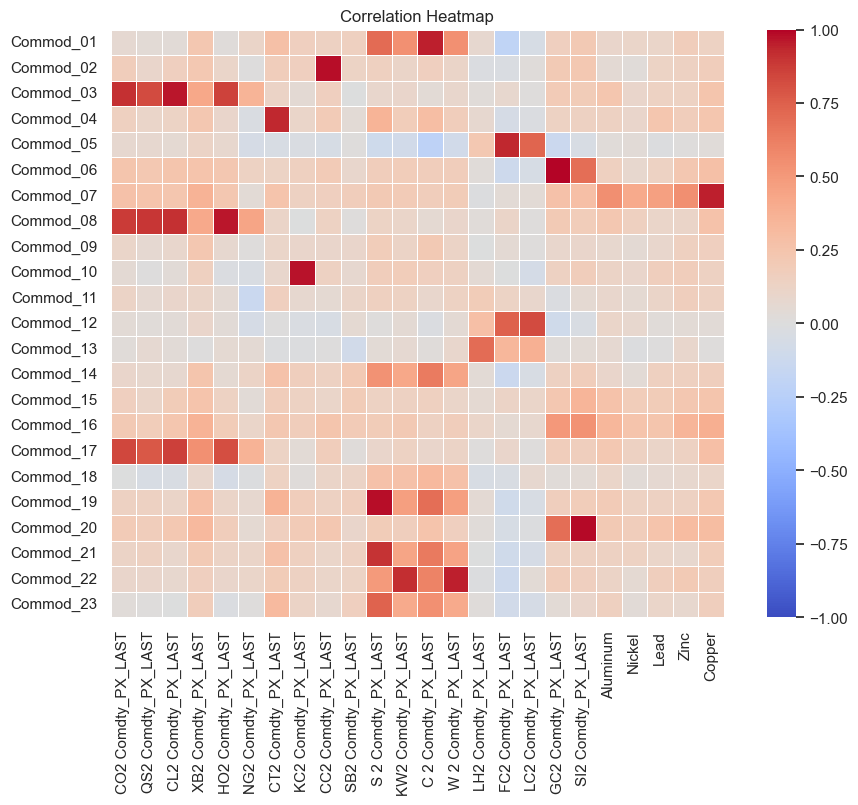

In [92]:
plt.figure(figsize=(10, 8))
corr_matrix_float = corr_matrix.astype(float)
sns.heatmap(
    corr_matrix_float,
    annot=False,      
    fmt=".2f",       
    cmap="coolwarm",  
    vmin=-1, vmax=1,  
    square=True,
    linewidths=0.5,
    cbar=True
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [93]:
optimal_pairs_df, col_ind, row_ind = decide_optimal_pairs(corr_matrix_float)

In [94]:
optimal_pairs_df

,Commodity_1,Commodity_2,Correlation
0,Commod_06,GC2 Comdty_PX_LAST,0.995992
1,Commod_20,SI2 Comdty_PX_LAST,0.990623
2,Commod_02,CC2 Comdty_PX_LAST,0.983558
3,Commod_19,S 2 Comdty_PX_LAST,0.976773
4,Commod_10,KC2 Comdty_PX_LAST,0.972272
5,Commod_03,CL2 Comdty_PX_LAST,0.962044
6,Commod_08,HO2 Comdty_PX_LAST,0.961412
7,Commod_01,C 2 Comdty_PX_LAST,0.952888
8,Commod_22,W 2 Comdty_PX_LAST,0.946210
9,Commod_07,Copper,0.945852


## Alternative Approach 2

In [91]:


clean_data_file_path = "clean_1970_2008_commodities_data.csv"
clean_data_file_new = "clean_2009_2024_commodities_data.csv"
clean_data_df_1970 = pd.read_csv(clean_data_file_path)
clean_data_df_2009 = pd.read_csv(clean_data_file_new)


combined_metrics_df_1970 = combine_metrics(clean_data_df_1970)

combined_metrics_df_2009 = combine_metrics(clean_data_df_2009)
df = pd.concat([clean_data_df_1970,clean_data_df_1970],ignore_index=True)
df = df[df["Contract"] <= 4]
df['Date'] = pd.to_datetime(df['Date'])
df['YearMonth'] = df['Date'].dt.to_period('M')
last_prices = df.groupby(['Commodity', 'YearMonth', 'Contract']).apply(
    lambda x: x.loc[x['Date'].idxmax()]
).reset_index(drop=True)
avg_price = last_prices.groupby(['Commodity', 'YearMonth'])['ClosePrice'].mean().reset_index()
avg_price_pivot = avg_price.pivot(index='YearMonth', columns='Commodity', values='ClosePrice')
monthly_return = avg_price_pivot.pct_change()
pivot_table = df.pivot_table(values='ClosePrice', index=['YearMonth'],columns="Commodity", aggfunc="mean")
monthly_return["Month"] = pd.to_datetime(
    monthly_return.index.astype(str), format="%Y-%m"
)


In [92]:
monthly_return['yyyymm'] = monthly_return["Month"].dt.strftime('%Y%m')

In [93]:
monthly_return = monthly_return.set_index("yyyymm")

In [94]:
corr_matrix = generate_corr_matrix(monthly_return, hkm_df)

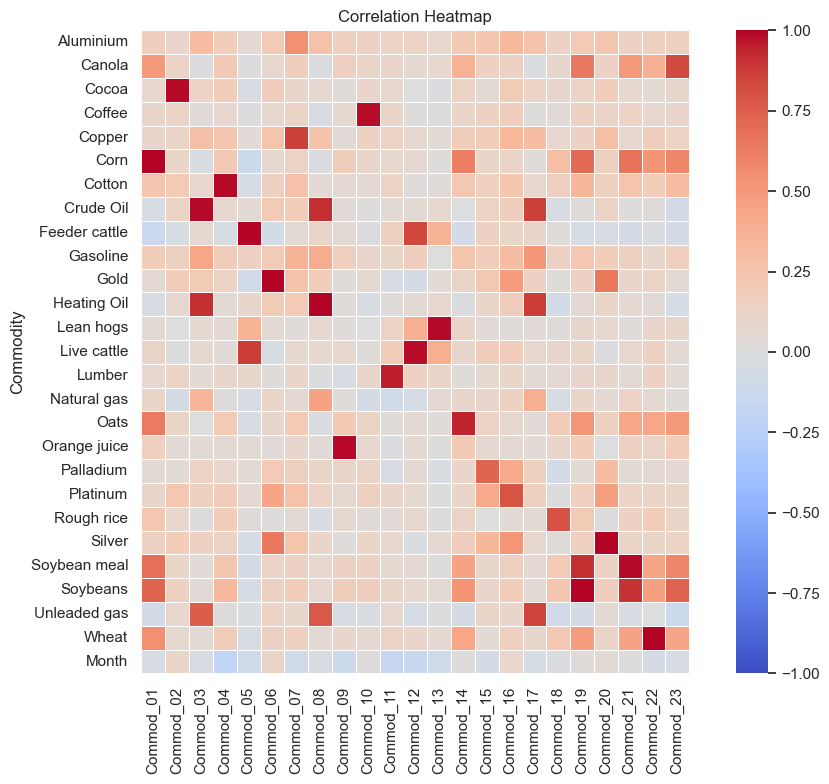

In [95]:
plt.figure(figsize=(10, 8))
corr_matrix_float = corr_matrix.astype(float)
sns.heatmap(
    corr_matrix_float,
    annot=False,      
    fmt=".2f",       
    cmap="coolwarm",  
    vmin=-1, vmax=1,  
    square=True,
    linewidths=0.5,
    cbar=True
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [96]:
optimal_pairs_df = decide_optimal_pairs(corr_matrix_float)

In [97]:
optimal_pairs_df

,Commodity_1,Commodity_2,Correlation
0,Gold,Commod_06,0.998063
1,Silver,Commod_20,0.996785
2,Heating Oil,Commod_08,0.995794
3,Feeder cattle,Commod_05,0.995749
4,Soybeans,Commod_19,0.994824
5,Wheat,Commod_22,0.993217
6,Corn,Commod_01,0.992310
7,Cocoa,Commod_02,0.990959
8,Soybean meal,Commod_21,0.990531
9,Lean hogs,Commod_13,0.988593
